# ***IMPORT LIBARY***

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import cv2
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import joblib

from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from torch.utils.data import Dataset,DataLoader, random_split
from sklearn.model_selection import train_test_split
from datetime import datetime
from tqdm import tqdm

import warnings 
warnings.filterwarnings('ignore')

# ***READ AND PREAPARE DATA***

In [2]:
data_root_path = '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023'
dir_train = []
for dir in os.listdir(data_root_path):
    dir_train.append(os.path.join(data_root_path,dir))
dir_train = sorted(dir_train)

In [3]:
dir_train

['/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-07',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-08',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-09',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-10',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-11',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-12',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-13',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-14',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-dataset/7-18.9.2023/7-18.9.2023/2023-09-15',
 '/kaggle/input/sky-images-and-solar-radiation-measurement-datas

In [4]:
def parse_filename(filename):
    base = os.path.basename(filename)
    name = base.split('.jpg')[0] 
    time_str, radiation = name.split('_')
    dt = datetime.strptime(time_str, '%Y-%m-%d-%H-%M-%S')
    return dt, float(radiation)

data = []
for dir in dir_train:
    for file in os.listdir(dir):
        if file.endswith('.jpg'):
            dt, radiation = parse_filename(file)
            data.append({'datetime': dt, 'radiation': radiation, 'filename':os.path.join(dir,file)})


df = pd.DataFrame(data).sort_values('datetime')

In [5]:
len(df)

68708

In [6]:
df.head()

,datetime,radiation,filename
785,2023-09-07 05:00:06,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...
4723,2023-09-07 05:00:16,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...
5662,2023-09-07 05:00:26,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...
1268,2023-09-07 05:00:36,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...
1202,2023-09-07 05:00:46,-0.1,/kaggle/input/sky-images-and-solar-radiation-m...


In [7]:
df.isnull().sum()

datetime     0
radiation    0
filename     0
dtype: int64

# ***VISUALIZE DATA***

In [8]:
start = '2023-09-07 05:00:06'
end = '2023-09-18 19:57:53'
df_filtered = df[(df['datetime'] >= start) & (df['datetime'] <= end)]

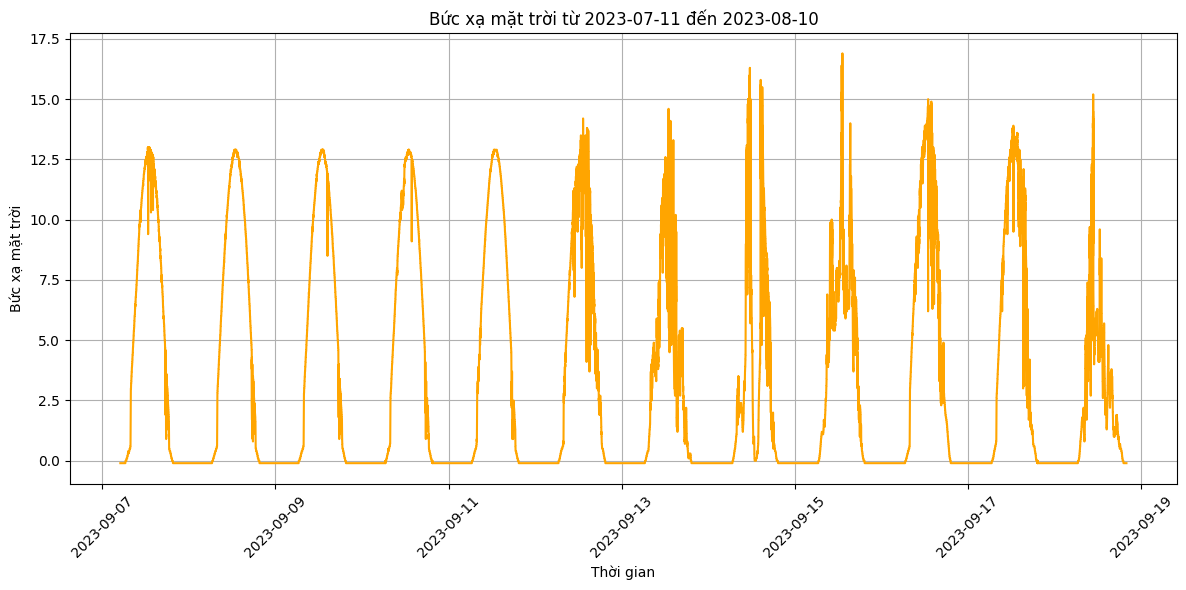

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['datetime'], df_filtered['radiation'],color = 'orange')
plt.title('Bức xạ mặt trời từ 2023-07-11 đến 2023-08-10')
plt.xlabel('Thời gian')
plt.ylabel('Bức xạ mặt trời')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ***CREATE DATASET, DATA LOADER***

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = torch.tensor([0.0]).to(device)

# ***IMAGE FEATURE EXTRACTION***

In [11]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
resnet = models.resnet50(pretrained=True)

modules = list(resnet.children())[:-2] 
cnn_backbone = nn.Sequential(*modules, nn.AdaptiveAvgPool2d((1, 1))) 

feature_extractor = nn.Sequential(
    cnn_backbone,
    nn.Flatten(),              # (B, 2048)
    nn.Linear(2048, 512)       # → (B, 512)
).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]


In [12]:
def feature_extraction(filenames, feature_extractor):
    feature_extractor.eval()
    image_features = []

    for img_path in tqdm(filenames):
        img = Image.open(img_path).convert('RGB')
        img_tensor = image_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            feat = feature_extractor(img_tensor)  # (1, 512)
            feat = feat.squeeze(0).cpu()          # (512,)
            image_features.append(feat)

    return image_features

image_features = feature_extraction(df['filename'], feature_extractor)
len(image_features)

100%|██████████| 68708/68708 [28:57<00:00, 39.55it/s]


68708

In [40]:
class RadiationDataset(Dataset):
    def __init__(self, df, image_features, sequence_length=60, forecast_horizon=30, stride=15):
        self.df = df
        self.image_features = image_features
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon
        self.stride = stride

    def __len__(self):
        valid_len = len(self.df) - self.sequence_length - self.forecast_horizon
        return max(0, valid_len // self.stride)
    def __getitem__(self, idx):
        base_idx = idx * self.stride
        img_seq = []
        rad_seq = []

        for i in range(self.sequence_length):
            img_feat = self.image_features[base_idx + i]
            img_seq.append(img_feat)
            rad_seq.append(self.df.iloc[base_idx + i]['radiation'])

        img_seq = torch.stack(img_seq)
        rad_seq = torch.tensor(rad_seq, dtype=torch.float32)
        target = torch.tensor(self.df.iloc[base_idx + self.sequence_length + self.forecast_horizon - 1]['radiation'], dtype=torch.float32)

        return img_seq, rad_seq, target

In [41]:
sequence_length = 60
forecast_horizon = 30


split_time = int(0.8 * len(df))


train_df = df.iloc[:split_time].reset_index(drop=True)
val_df = df.iloc[split_time:].reset_index(drop=True)


train_image_features = image_features[:split_time]
val_image_features = image_features[split_time:]

train_dataset = RadiationDataset(
    df=train_df,
    image_features=train_image_features,
    sequence_length=sequence_length,
    forecast_horizon=forecast_horizon
)

val_dataset = RadiationDataset(
    df=val_df,
    image_features=val_image_features,
    sequence_length=sequence_length,
    forecast_horizon=forecast_horizon
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

In [42]:
import torch
import torch.nn as nn

class MITransformerModel(nn.Module):
    def __init__(self, img_dim=512, rad_dim=1, d_model=64, nhead=4, num_layers=2):
        super(MITransformerModel, self).__init__()

        # Embedding layers
        self.img_linear = nn.Linear(img_dim, d_model)
        self.rad_linear = nn.Linear(rad_dim, d_model)

        # Positional encoding
        self.pos_enc = nn.Parameter(torch.randn(1, 100, d_model))  # max seq_len = 100

        # Transformer encoders
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.img_transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.rad_transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Normalization & dropout
        self.norm_img = nn.LayerNorm(d_model)
        self.norm_rad = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.3)

        # Fusion & classification
        self.fc = nn.Sequential(
            nn.Linear(d_model * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, img_feat_seq, rad_seq):
        """
        img_feat_seq: [B, T, 512]  -- image feature sequence
        rad_seq:      [B, T] or [B, T, 1]  -- radar/ts sequence
        """
        B, T, _ = img_feat_seq.size()
    
        # Fix rad_seq shape if needed
        if rad_seq.dim() == 2:
            rad_seq = rad_seq.unsqueeze(-1)  # [B, T, 1]
    
        # Project input features to d_model
        img_embed = self.img_linear(img_feat_seq) + self.pos_enc[:, :T]
        rad_embed = self.rad_linear(rad_seq) + self.pos_enc[:, :T]
    
        # Transformer encoding
        img_encoded = self.img_transformer(img_embed)
        rad_encoded = self.rad_transformer(rad_embed)
    
        # Last timestep features
        img_feat = self.norm_img(img_encoded[:, -1, :])
        rad_feat = self.norm_rad(rad_encoded[:, -1, :])
    
        img_feat = self.dropout(img_feat)
        rad_feat = self.dropout(rad_feat)
    
        combined = torch.cat([img_feat, rad_feat], dim=1)
        output = self.fc(combined)
        return output.squeeze()
    


In [43]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Khởi tạo mô hình
model = MITransformerModel().to(device)

# Hàm mất mát
criterion = nn.MSELoss()

# Tối ưu hóa Adam
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

# Lịch trình điều chỉnh learning rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


In [44]:
num_epochs = 20
train_losses = []
val_losses = []

all_val_preds = []
all_val_targets = []

for epoch in range(num_epochs):
    
    model.train()
    running_train_loss = 0.0

    for images, rad_seq, target in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        rad_seq = rad_seq.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        outputs = model(images, rad_seq)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)  # tổng loss

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    

    model.eval()
    running_val_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for images, rad_seq, target in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            rad_seq = rad_seq.to(device)
            target = target.to(device)

            outputs = model(images, rad_seq)
            loss = criterion(outputs, target)

            running_val_loss += loss.item() * images.size(0)

            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(target.cpu().numpy())

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    all_val_preds.append(val_preds)
    all_val_targets.append(val_targets)

    scheduler.step(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]:Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")

Validation: 100%|██████████| 57/57 [00:02<00:00, 25.98it/s]


Epoch [1/20]:Train Loss: 6.2412 - Val Loss: 1.4113


Validation: 100%|██████████| 57/57 [00:02<00:00, 26.09it/s]


Epoch [2/20]:Train Loss: 2.2949 - Val Loss: 2.0320


Validation: 100%|██████████| 57/57 [00:02<00:00, 25.95it/s]


Epoch [3/20]:Train Loss: 2.1264 - Val Loss: 1.3586


Validation: 100%|██████████| 57/57 [00:02<00:00, 26.12it/s]


Epoch [4/20]:Train Loss: 1.9928 - Val Loss: 1.2206


Validation: 100%|██████████| 57/57 [00:02<00:00, 25.79it/s]


Epoch [5/20]:Train Loss: 1.9424 - Val Loss: 1.5450


Validation: 100%|██████████| 57/57 [00:02<00:00, 25.14it/s]


Epoch [6/20]:Train Loss: 1.8780 - Val Loss: 1.2273


Validation: 100%|██████████| 57/57 [00:02<00:00, 25.25it/s]


Epoch [7/20]:Train Loss: 1.8612 - Val Loss: 1.2171


Validation: 100%|██████████| 57/57 [00:02<00:00, 25.28it/s]


Epoch [8/20]:Train Loss: 1.8276 - Val Loss: 1.2615


Validation: 100%|██████████| 57/57 [00:02<00:00, 25.93it/s]


Epoch [9/20]:Train Loss: 1.8458 - Val Loss: 1.3254


Validation: 100%|██████████| 57/57 [00:02<00:00, 25.68it/s]


Epoch [10/20]:Train Loss: 1.6681 - Val Loss: 1.2677


Validation: 100%|██████████| 57/57 [00:02<00:00, 25.95it/s]


Epoch [11/20]:Train Loss: 1.6345 - Val Loss: 1.1651


Validation: 100%|██████████| 57/57 [00:02<00:00, 25.35it/s]


Epoch [12/20]:Train Loss: 1.5986 - Val Loss: 1.1992


Validation: 100%|██████████| 57/57 [00:02<00:00, 26.26it/s]


Epoch [13/20]:Train Loss: 1.6618 - Val Loss: 1.3363


Validation: 100%|██████████| 57/57 [00:02<00:00, 22.15it/s]


Epoch [14/20]:Train Loss: 1.6318 - Val Loss: 1.4257


Validation: 100%|██████████| 57/57 [00:02<00:00, 25.86it/s]


Epoch [15/20]:Train Loss: 1.4978 - Val Loss: 1.1872


Validation: 100%|██████████| 57/57 [00:02<00:00, 26.45it/s]


Epoch [16/20]:Train Loss: 1.5312 - Val Loss: 1.1886


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.73it/s]


Epoch [17/20]:Train Loss: 1.5080 - Val Loss: 1.2257


Validation: 100%|██████████| 57/57 [00:02<00:00, 23.69it/s]


Epoch [18/20]:Train Loss: 1.4899 - Val Loss: 1.1501


Validation: 100%|██████████| 57/57 [00:02<00:00, 26.06it/s]


Epoch [19/20]:Train Loss: 1.5141 - Val Loss: 1.2200


Validation: 100%|██████████| 57/57 [00:02<00:00, 26.04it/s]

Epoch [20/20]:Train Loss: 1.4165 - Val Loss: 1.1773


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(all_val_preds[-1], all_val_targets[-1])
print(f"Mean Absolute Error (MAE): {mae:.4f}")

mse = mean_squared_error(all_val_preds[-1], all_val_targets[-1])
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

r2 = r2_score(all_val_preds[-1], all_val_targets[-1])
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.5602
Root Mean Squared Error (RMSE): 1.0851
R-squared (R²): 0.9393


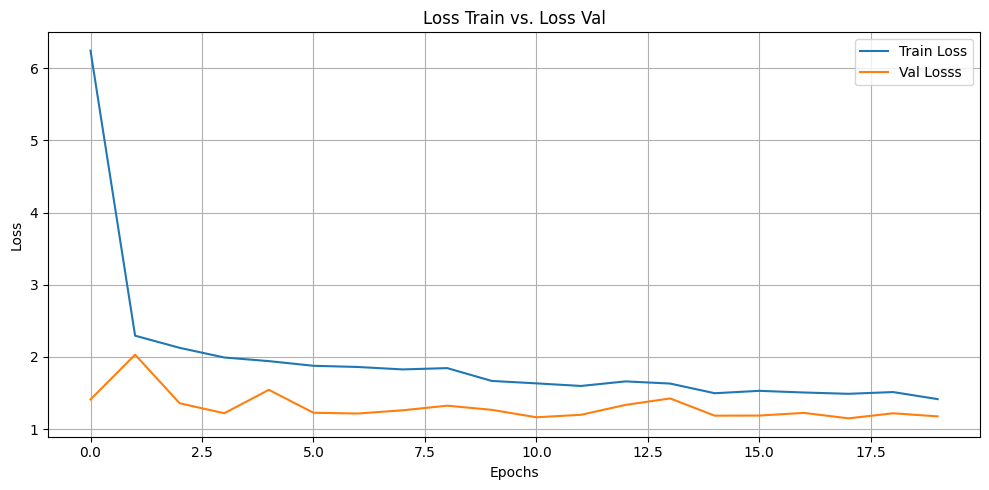

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Losss')
plt.title('Loss Train vs. Loss Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

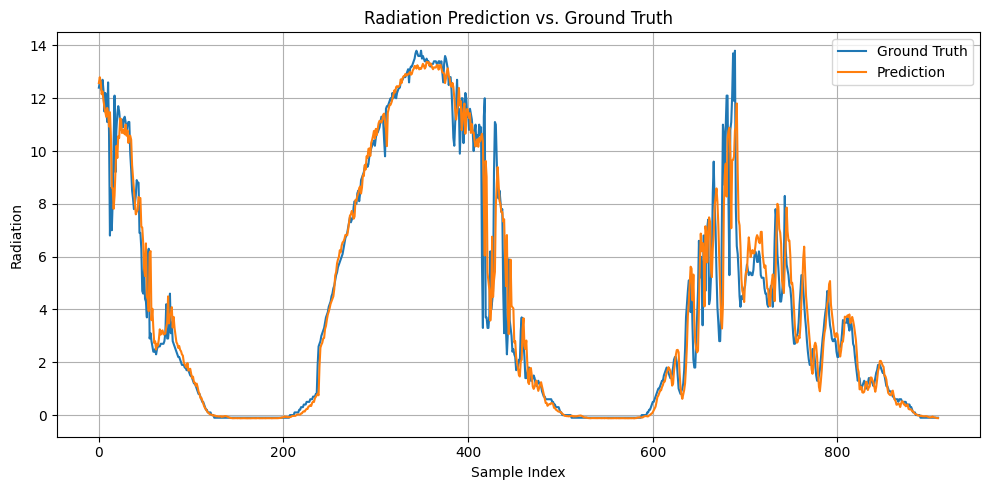

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(all_val_targets[-1], label='Ground Truth')
plt.plot(all_val_preds[-1], label='Prediction')
plt.title('Radiation Prediction vs. Ground Truth')
plt.xlabel('Sample Index')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
torch.save(model.state_dict(), 'model_1.pth')